In [8]:
!pip install torcheval

In [24]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
random.seed(9)



# Define transforms to be applied to the images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomRotation(degrees=15),  # Random rotation up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image data
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image data
])

# Paths to the directories containing training and validation data
train_data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_data_directory = '/kaggle/input/new-plant-diseases-dataset/test'



# Load the training dataset using ImageFolder
train_full_dataset = ImageFolder(root=train_data_dir, transform=train_transform)
print(f"Training size: {len(train_full_dataset.imgs)}")

# Load the validation dataset using ImageFolder
val_full_dataset = ImageFolder(root=val_data_dir, transform=transform)
print(f"Validation size: {len(val_full_dataset.imgs)}")

# Load the test dataset using ImageFolder
test_dataset = ImageFolder(root=test_data_directory, transform=transform)
print(f"Test size: {len(test_dataset.imgs)}", end='\n\n')


def get_random_indices(full_dataset):
    selected_indices = []

    # Iterate over the classes in the dataset
    for class_idx in range(len(full_dataset.classes)):
        # Get the indices of images belonging to the current class
        class_indices = [idx for idx, (_, label_idx) in enumerate(full_dataset.imgs) if label_idx == class_idx]
        # Select a percentage of images from the current class
        num_selected = int(len(class_indices) * 0.5)
        selected_indices.extend(random.sample(class_indices, num_selected))

    return selected_indices

selected_train_indices = get_random_indices(train_full_dataset)
selected_val_indices = get_random_indices(val_full_dataset)

train_subset_dataset = Subset(train_full_dataset, selected_train_indices)
val_subset_dataset = Subset(val_full_dataset, selected_val_indices)
print(f"Reduced training size: {len(train_subset_dataset)}")
print(f"Reduced validation size: {len(val_subset_dataset)}")


# Create DataLoaders
batch_size = 256
train_dataloader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset_dataset, batch_size=batch_size, shuffle=False)
# train_dataloader = DataLoader(train_full_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_full_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training size: 70295
Validation size: 17572
Test size: 33

Reduced training size: 35141
Reduced validation size: 8777


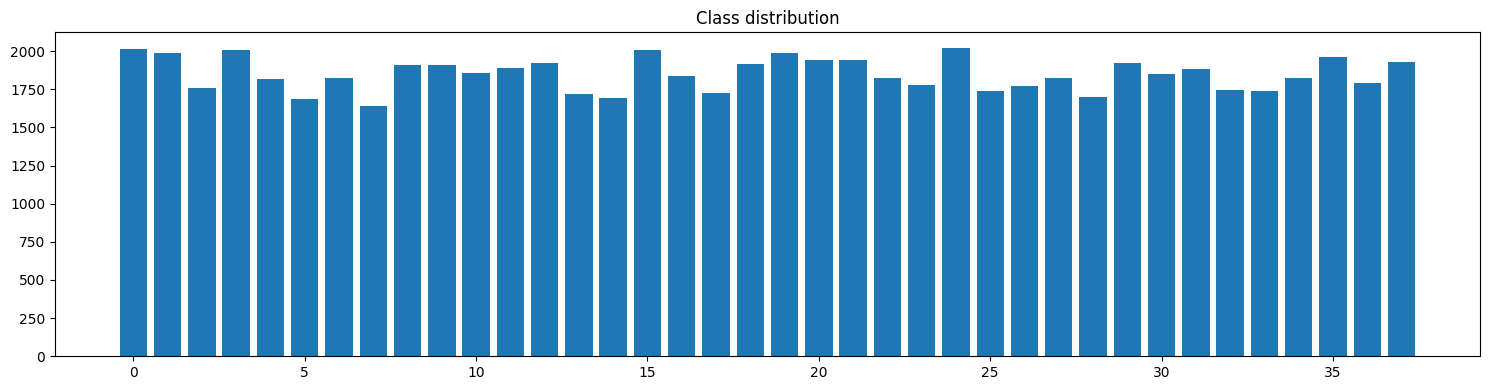

In [10]:
import matplotlib.pyplot as plt

class_dict = {}
for cid in range(len(train_full_dataset.classes)):
    class_count = len([idx for idx, (_, label_idx) in enumerate(train_full_dataset.imgs) if label_idx == cid])
    class_dict[cid] = class_count
    
plt.figure(figsize=(15,4))
plt.bar(class_dict.keys(), class_dict.values())
plt.title("Class distribution")
plt.tight_layout()
plt.show()

In [11]:
import os
import cv2
import json

train_test_labels = {'AppleCedarRust': 'Apple___Cedar_apple_rust',
                    'AppleScab': 'Apple___Apple_scab',
                    'CornCommonRust': 'Corn_(maize)___Common_rust_',
                    'PotatoEarlyBlight': 'Potato___Early_blight',
                    'PotatoHealthy': 'Potato___healthy',
                    'TomatoEarlyBlight': 'Tomato___Early_blight',
                    'TomatoHealthy': 'Tomato___healthy',
                    'TomatoYellowCurlVirus': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
                    }

test_data_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'

test_labels = []
for td in sorted(os.listdir(test_data_dir)):
    test_labels.append(train_test_labels[td[:-5]])


class_dict = {j: i for i, j in enumerate(train_full_dataset.classes)}
test_labels = [class_dict[x] for x in test_labels]
test_labels = torch.tensor(test_labels, dtype=torch.int64)


with open('class_mapper.json', 'w') as json_file:
    json.dump(class_dict, json_file)

In [12]:
import torch.nn as nn
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(weights='DEFAULT')


for name, param in vgg16.named_parameters():
    if 'features.0' in name or 'features.2' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the last fully connected layer for the number of classes in your dataset
num_classes = len(train_full_dataset.classes)
vgg16.classifier[-1] = nn.Linear(in_features=vgg16.classifier[-1].in_features, out_features=num_classes)


if torch.cuda.device_count() > 1:
    vgg16 = nn.DataParallel(vgg16)
    
vgg16 = vgg16.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vgg16.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
# import torch.nn.functional as F

# # Train the model
# num_epochs = 10
# vgg16.train()  # Set the model to train mode

# for epoch in range(num_epochs):
# #     running_loss = 0.0
#     running_loss = torch.zeros((len(train_dataloader), ))
#     for i, (inputs, labels) in enumerate(train_dataloader):
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = vgg16(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss[i] = loss.item()
# #         running_loss += loss.item()
# #     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss.mean():.04f}")

# # Validate the model
# vgg16.eval()  # Set the model to evaluation mode
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, labels in val_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = vgg16(inputs)
#         predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Validation Accuracy: {100 * correct / total:.02f}%")

In [ ]:
# Train the model
import torch.nn.functional as F


num_epochs = 15
# train_outs = []
# val_outs = []

for epoch in range(num_epochs):
    vgg16.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_running_loss/len(train_dataloader):.04f}, Training Accuracy: {100 * train_correct / train_total:.02f}%", end="\t")
    train_outs.append((train_running_loss/len(train_dataloader), train_correct / train_total))

    # Validate the model
    vgg16.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_running_loss/len(val_dataloader):.04f}, Validation Accuracy: {100 * val_correct / val_total:.02f}%")
    val_outs.append((val_running_loss/len(val_dataloader), val_correct / val_total))

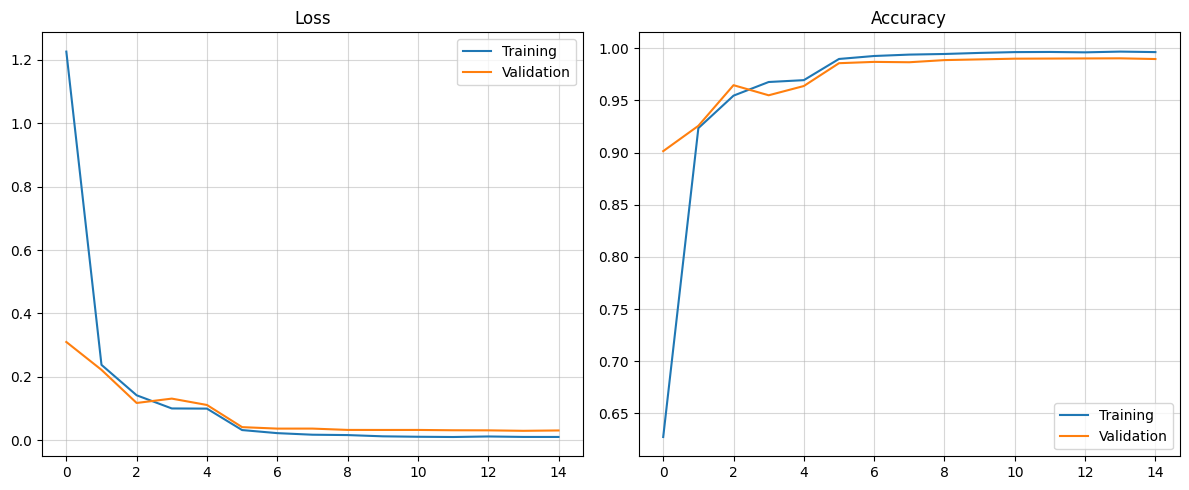

In [20]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in train_outs], label='Training')
plt.plot([x[0] for x in val_outs], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot([x[1] for x in train_outs], label='Training')
plt.plot([x[1] for x in val_outs], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [21]:
# test_images, test_labels = test_images.to(device), test_labels.to(device)
test_labels = test_labels.to(device)

vgg16.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = vgg16(inputs.to(device))
        loss = criterion(outputs, test_labels)
        predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        accuracy = (predicted == test_labels).sum().item()
        print(f"Test Loss: {loss:.04f}, Test Accuracy: {100 * accuracy/inputs.size(0):.02f}%")

Test Loss: 0.0132, Test Accuracy: 100.00%


In [22]:
import torcheval.metrics.functional as eval_metric
f_score = eval_metric.multiclass_f1_score(predicted.cpu(), test_labels.cpu(), num_classes=38, average='macro')
precision = eval_metric.multiclass_precision(predicted.cpu(), test_labels.cpu(), num_classes=38, average='macro')

print(f"Macro precision: {precision.item()}")
print(f"Macro F-score: {f_score.item()}")

Macro precision: 1.0
Macro F-score: 1.0


In [23]:
# torch.save(vgg16.module.state_dict(), 'VGG16_transfer_learning_model_best2.pth')

param_names_to_save = [k for k, v in vgg16.module.named_parameters() if v.requires_grad==True]

params_to_save = {k: v for k, v in vgg16.module.state_dict().items() if k in param_names_to_save}

# Save only the trained weights
torch.save(params_to_save, 'VGG16_transfer_learning_trained_weights.pth')